In [14]:
import sys
import csv
import time
import datetime
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [15]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))


In [16]:
ticker='DIS'
period1 = int(time.mktime(datetime.datetime(2015, 1, 1, 0, 0).timetuple()))
period2 = int(time.mktime(datetime.datetime.now().timetuple()))
interval = '1d' # 1d, 1m
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
df_dis = pd.read_csv(query_string)

In [17]:
df_dis['symbol']='DIS'
df_dis.to_csv('data/DIS.csv')
df_dis.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol
1772,2022-01-14,152.350006,152.619995,148.419998,151.940002,151.940002,16821900,DIS
1773,2022-01-18,151.110001,153.130005,149.830002,152.270004,152.270004,10419500,DIS
1774,2022-01-19,150.839996,152.860001,149.960007,150.110001,150.110001,10413200,DIS
1775,2022-01-20,150.910004,152.660004,147.149994,147.619995,147.619995,11760400,DIS
1776,2022-01-21,141.229996,141.869995,136.630005,137.380005,137.380005,34457000,DIS


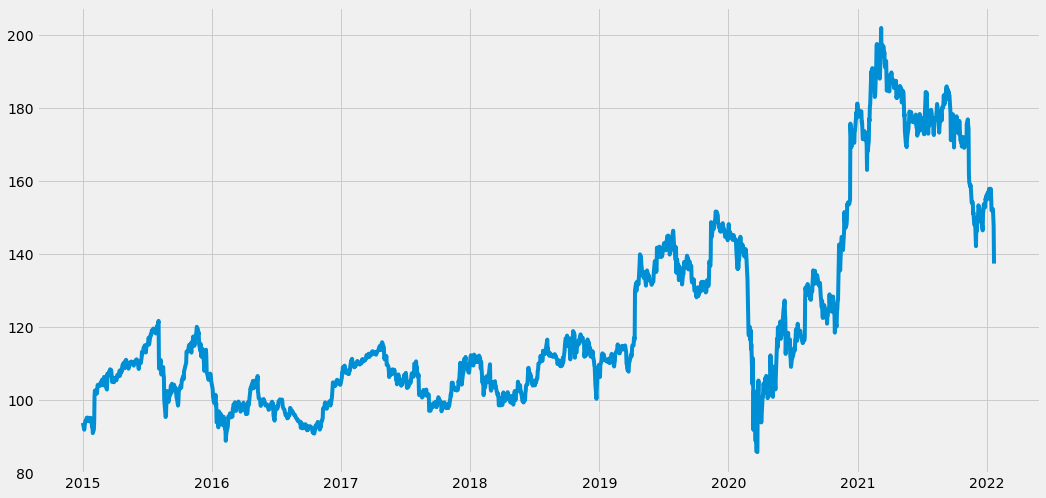

In [18]:
#setting index as date
df_dis['Date'] = pd.to_datetime(df_dis.Date,format='%Y-%m-%d')
df_dis.index = df_dis['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df_dis['Close'], label='Precio de Cierre Historico')

### Long Short Term Memory (LSTM)

In [19]:
data = df_dis.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df_dis)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values



train = dataset[0:1420,:]
valid = dataset[1420:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

valid = new_data[1420:]
valid['Predictions'] = closing_price
ml_data = valid

1360/1360 - 34s - loss: 0.0015 - 34s/epoch - 25ms/step


<ipython-input-19-8923e347228f>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


<ipython-input-20-2e1ded5fbc12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


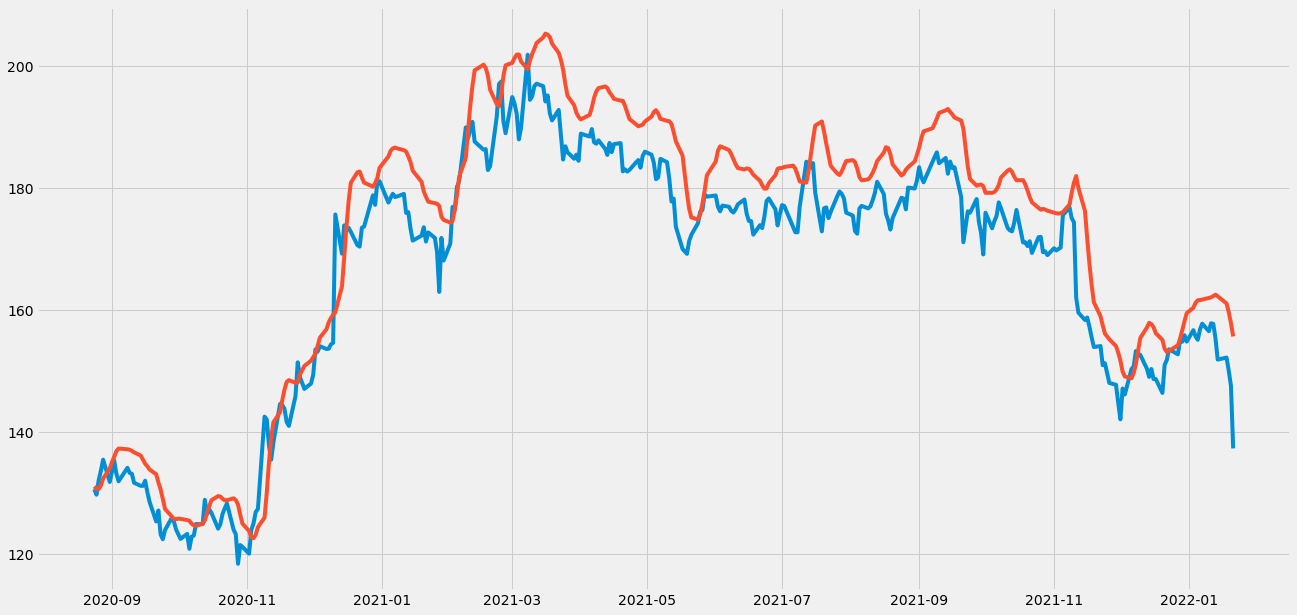

In [20]:
#for plotting
# train = new_data[:1007]
valid = new_data[1420:]
valid['Predictions'] = closing_price
# plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

In [21]:
ml_data['Symbols']= 'DIS'
ml_data = ml_data.reset_index()
ml_data.to_csv('data_prediction/DIS_data_LSTM.csv')

<ipython-input-21-8f0c9021a496>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml_data['Symbols']= 'DIS'


In [22]:
ml_data.tail()

,Date,Close,Predictions,Symbols
352,2022-01-14,151.940002,162.314896,DIS
353,2022-01-18,152.270004,161.139954,DIS
354,2022-01-19,150.110001,159.688202,DIS
355,2022-01-20,147.619995,157.893341,DIS
356,2022-01-21,137.380005,155.730469,DIS
